Drumplot (Helicorder) With Data Select and Filtering
--

**What and How**

The purpose of this notebook is to provide non-seismologists with a relatively easy to use tool to make drumplots (helicorders) of a day of seismic data. In particular, it provides a capability to filter the data before plotting. This was identified as a short coming of existing products at the time of the April 2016 White Island eruption. Filtering can be important to enhance very long period (VLP) signals in seismic waveforms that can accompany explosive eruptions, but it can also enhance other signals with a specific frequency content.

Data are acquired from GeoNet's FDSN web servers. The archive server is used as the first choice, and if that does not contain the data (it only keeps data older than 7 days) then the near real-time server will be used instead (which contains the last 8 days of data.

Large signals can produce a trace that extends over much of the drumplot and obscures other parts of the plot. For that reason, large amplitude waves are clipped before plotting.


**Instructions**
1. Run the notebook. To do this, click 'Cell' in the dropdown menu, and then click 'Run All'.
2. Select the date and the data stream, and then click 'Retrieve data'.
3. This may take a few moments. Once the data have been retrieved, a message will be displayed.
4. If you want to filter the data, select the box labelled Filter? The default is no filtering. If you want to filter the waveform, you also need to select the bandpass filter range. The default is 0.1 to 10 Hz.
5. Depending on the amplitude of the signal, it may be necessary to adjust the plot gain, this scales the traces up or down. Some experimentation may be needed to find the best value. Try the default value first, it is suitable for many drumplots.
6. Click 'Show on screen' to display the drumplot below.
7. Large amplitudes are automatically clipped. The clip value is currently not adjustable by a user.
8. You can repeat steps 4-6 as many times as you want, adjusting filter parameters and plot gains, to get the drumplot looking the way you want. Each time you click on 'Show on screen', a new drumplot will be produced and will show below any existing drumplots.
9. To produce an output file suitable for printing, click on 'Output to file'. This will produce a file that is visible in the Jupyter Hub file manager tab in your browser. To save that file, click on the file name to open a view of the helicorder in another browser tab, then right click on the image and select 'Save image as ...'.
10. The image will be named station.location.component.network_yyyymmdd_filter.drum.png. Examples are WIZ.10.HHZ.NZ_20171031_bandpass_0.1-4.6.drum.png and WIZ.10.HHZ.NZ_20171031_nofilt.drum.png.

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [12]:
from IPython.display import HTML
from obspy.core import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Button, Layout
%matplotlib inline

In [13]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
current = False

In [16]:
#plot initialisation
filt = False
corners = 2
zerophase = False
defscale = 1e4
scale = defscale

#size ratio to match aspect ratio of print paper
xsize = 3200
ysize = int(xsize/1.4) 
size = (xsize,ysize)

#large trace clip
clip = 100000

In [17]:
def selsite(s):
  global site, stn, loc, cmp, net
  site = s['new']
  
  stn = site.split(".")[0]
  loc = site.split(".")[1]
  cmp = site.split(".")[2]
  net = site.split(".")[3]

def seldate(d):
  global pdate
  date = d['new']
  pdate = date.strftime("%Y%m%d")
  
def retrieve(r):
  global tr
  if (current):   #current data, last day, nrt client only
    time = UTCDateTime()
    client = Client('IRIS')
    st = client.get_waveforms(str(net), str(stn), str(loc), str(cmp), time - 86400, time, attach_response=True)
  else:   #older data
    time = UTCDateTime(pdate)
    client = Client('IRIS')
    st = client.get_waveforms(str(net), str(stn), str(loc), str(cmp), time, time + 86400, attach_response=True)
    print ('client successful')
    
  st.remove_sensitivity()
  st.merge(fill_value = 0.0) #merge streams, fill gaps with zeros
  tr = st[0]
  tr.data *= 1e9 #convert from m/s to nm/s
  tr.data = np.clip(tr.data, clip*-1, clip)
  print ('data retrieved')
  print (tr)

def bandpass(bp):
  global lp, hp
  lp, hp  = bp['new']

def filter(f):
  global filt  
  filt = f['new']

def gain(g):
  global magn, scale  
  magn = g['new']
  scale = defscale / magn

def screen(c):
    if (filt):
        trcp = tr.copy()
        trcp.filter('bandpass', freqmin=lp, freqmax=hp, corners=corners, zerophase=zerophase)
        title = site+'_'+pdate+'_bandpass_'+str(lp)+'-'+str(hp)
        trcp.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title)
    else:
        title = site + '_' + pdate + '_nofilt'
        tr.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title)

def output(o):
    if (filt):
        trcp = tr.copy()
        trcp.filter('bandpass', freqmin=lp, freqmax=hp, corners=corners, zerophase=zerophase)
        title = site+'_'+pdate+'_bandpass_'+str(lp)+'-'+str(hp)
        trcp.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title, outfile=title+'.drum.png')
    else:
        title = site+'_'+pdate+'_nofilt'
        tr.plot(type='dayplot', linewidth = 0.3, vertical_scaling_range= scale, size=size, color=('navy','blue','blue','blue'), title=title, outfile=title+'.drum.png')

In [18]:
s = widgets.Select(
    options=['select stream', 'HNR.00.BHZ.IU', 'WIZ.10.HHZ.NZ', 'WSRZ.10.HHZ.NZ', 'MAVZ.10.HHZ.NZ', 'FWVZ.10.HHZ.NZ', 'WHVZ.10.HHZ.NZ', 'TRVZ.10.HHZ.NZ', 'GLKZ.10.HHZ.NZ', 'KRVZ.10.EHZ.NZ'],
    value='select stream',
    description='Stream:',
    disabled=False
)
s.observe(selsite, names='value')

d = widgets.DatePicker(
  description='Date:')
d.observe(seldate, names='value')

r=widgets.Button(
    description='Retrieve data',
    disabled=False,
    button_style='success',
    tooltip='Retrieve data for plotting')
r.on_click(retrieve)

widgets.HBox([d, s, r])

HBox(children=(DatePicker(value=None, description='Date:'), Select(description='Stream:', options=('select stream', 'HNR.00.BHZ.IU', 'WIZ.10.HHZ.NZ', 'WSRZ.10.HHZ.NZ', 'MAVZ.10.HHZ.NZ', 'FWVZ.10.HHZ.NZ', 'WHVZ.10.HHZ.NZ', 'TRVZ.10.HHZ.NZ', 'GLKZ.10.HHZ.NZ', 'KRVZ.10.EHZ.NZ'), value='select stream'), Button(button_style='success', description='Retrieve data', style=ButtonStyle(), tooltip='Retrieve data for plotting')))

client successful
data retrieved
IU.HNR.00.BHZ | 2018-02-01T00:00:00.019500Z - 2018-02-01T23:59:59.994500Z | 40.0 Hz, 3456000 samples
client successful
data retrieved
IU.HNR.00.BHZ | 2018-02-02T00:00:00.019500Z - 2018-02-02T23:59:59.994500Z | 40.0 Hz, 3456000 samples
client successful
data retrieved
IU.HNR.00.BHZ | 2018-02-14T00:00:00.019500Z - 2018-02-14T23:59:59.994500Z | 40.0 Hz, 3456000 samples
client successful
data retrieved
IU.HNR.00.BHZ | 2018-01-28T00:00:00.019500Z - 2018-01-28T23:59:59.994500Z | 40.0 Hz, 3456000 samples


HBox(children=(Checkbox(value=False, description='Filter?', layout=Layout(width='10%')), FloatRangeSlider(value=(0.1, 10.0), description='band-pass:', max=10.0, min=0.05, readout_format='.1f', step=0.05), FloatSlider(value=1.0, description='plot gain:', max=10.0, min=0.1, readout_format='.1f'), Button(button_style='success', description='Show on screen', style=ButtonStyle(), tooltip='Make drumplot'), Button(button_style='success', description='Output to file', style=ButtonStyle(), tooltip='Make file copy')))

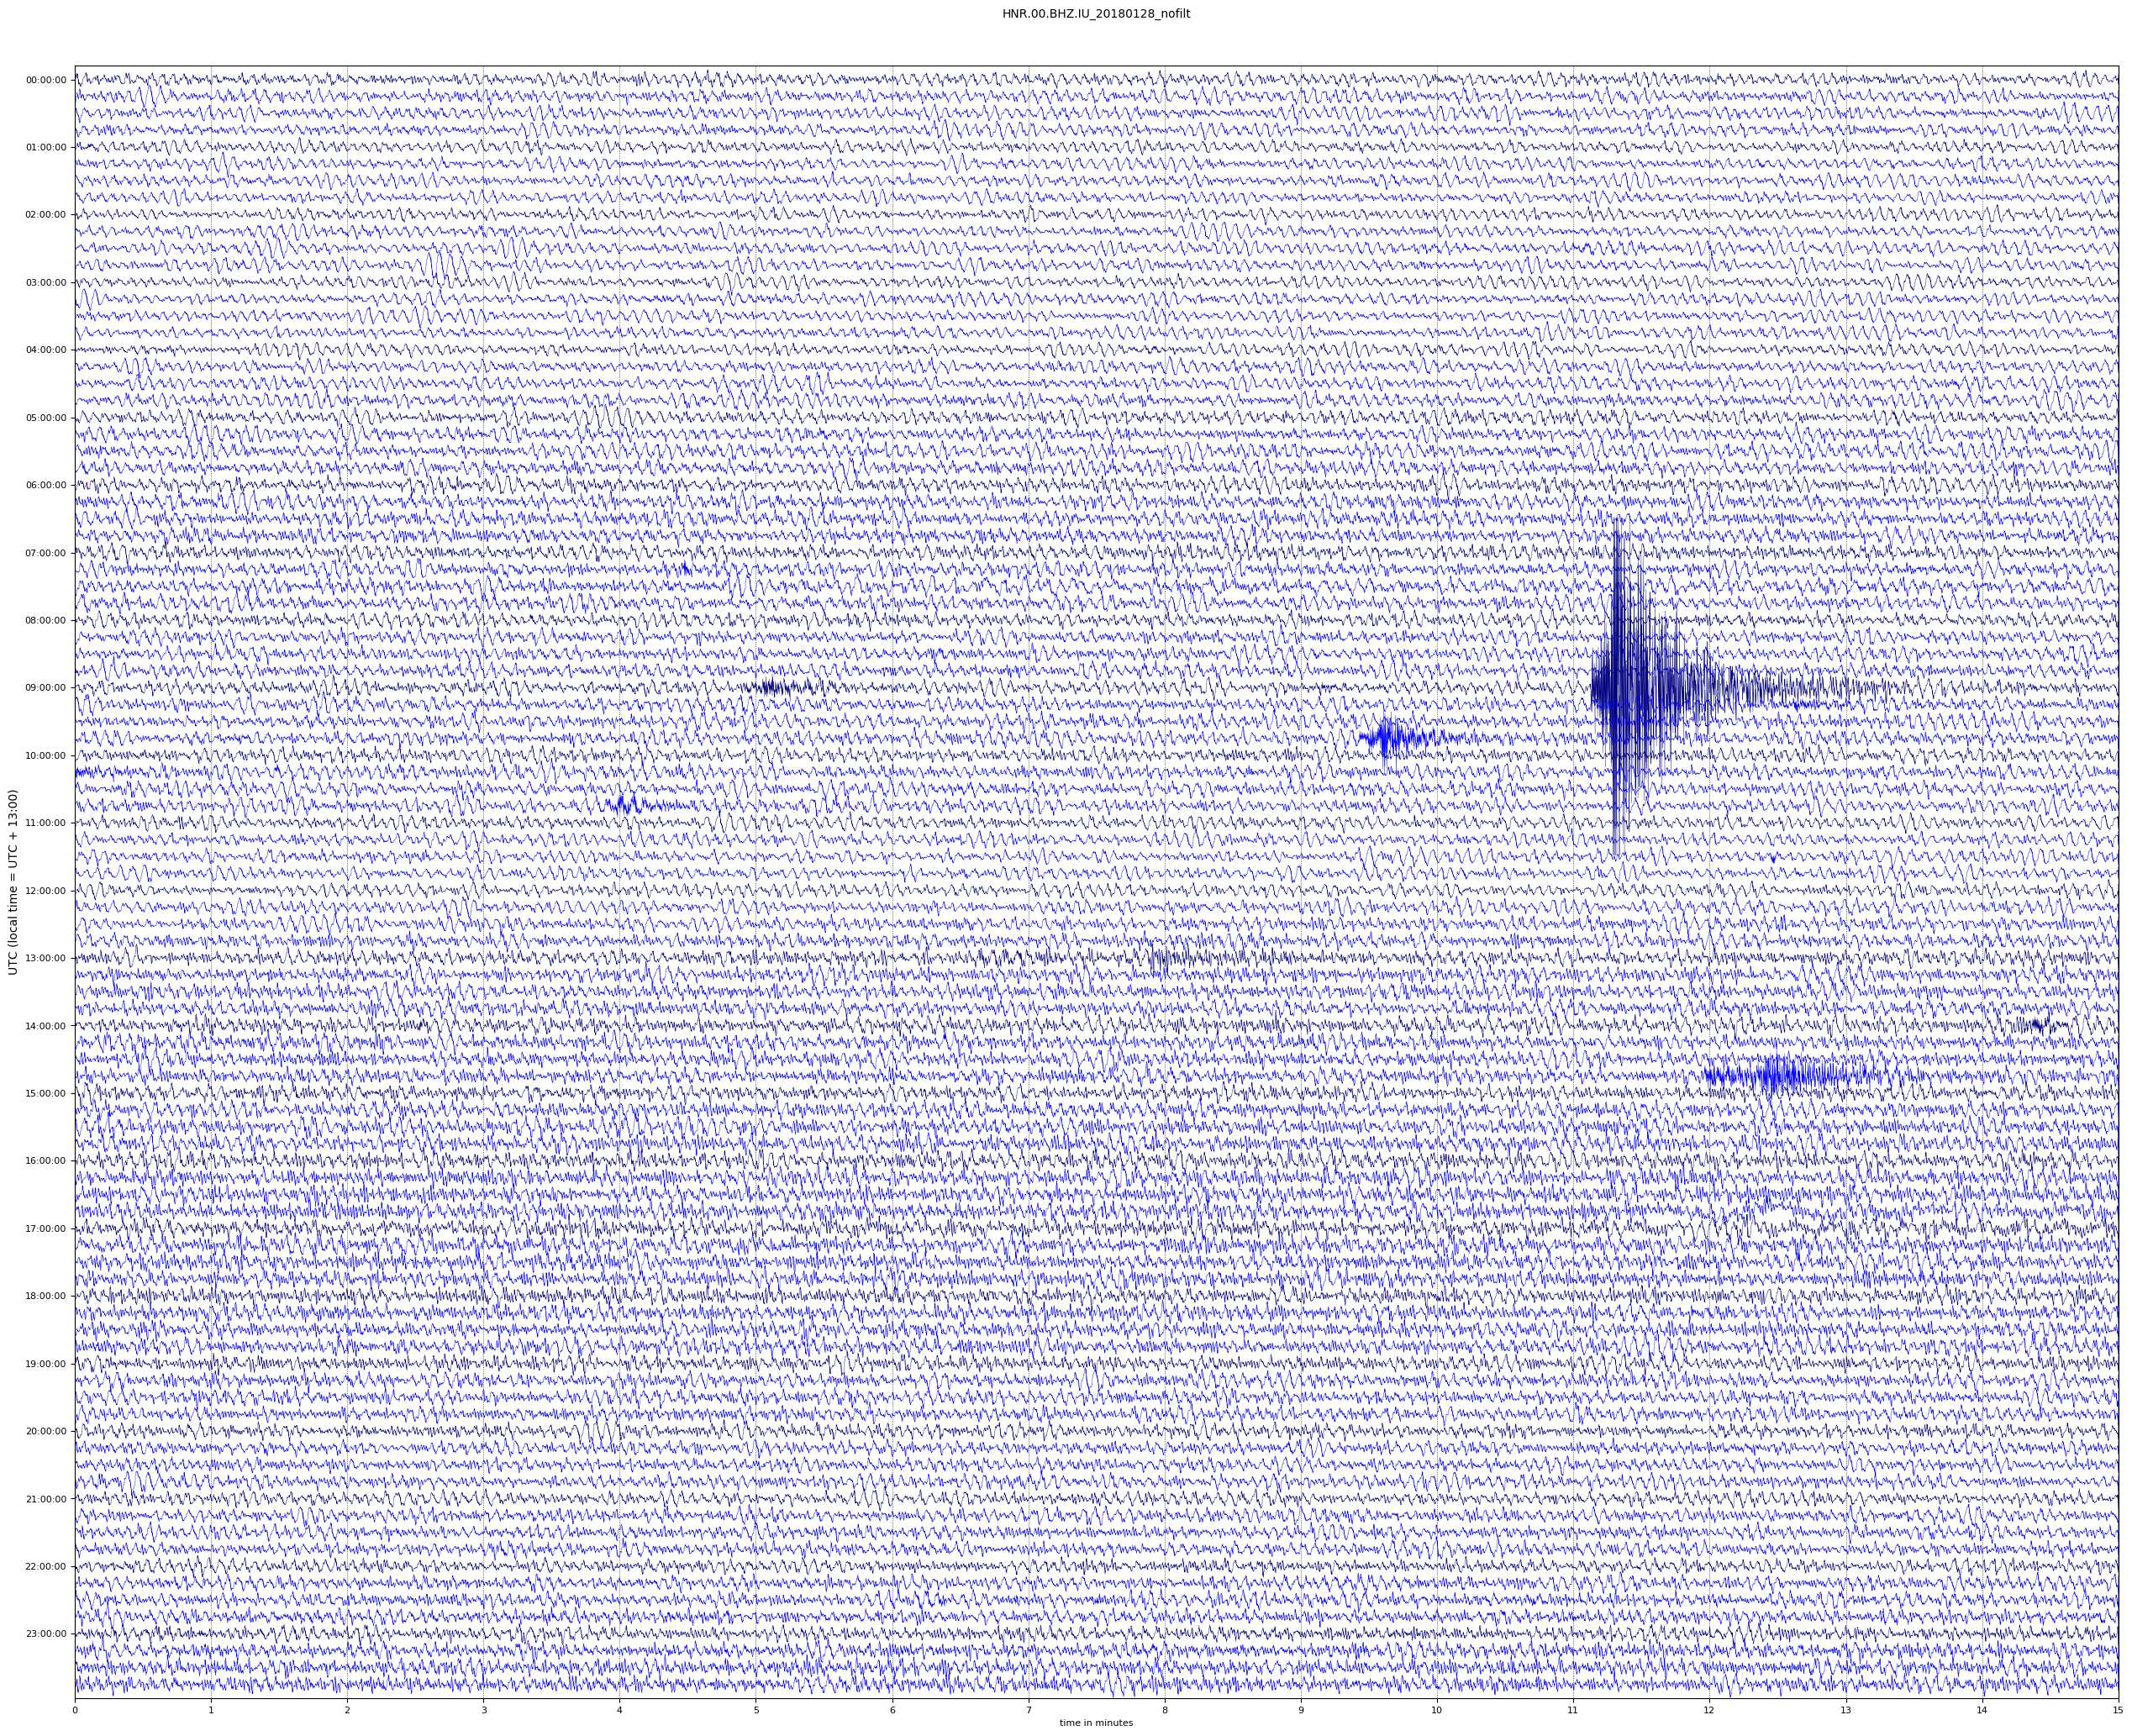

In [22]:
f=widgets.Checkbox(
    description='Filter?',
    value=False,
    tooltip='Set filtering',
    disabled=False,
    layout=widgets.Layout(width='10%'))
f.observe(filter,names='value')

b=widgets.FloatRangeSlider(
    value=[0.1, 10],
    min=0.05,
    max=10,
    step=0.05,
    description='band-pass:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white')
b.observe(bandpass, names='value')

g=widgets.FloatSlider(
    value=1,
    min=0.1,
    max=10,
    step=0.1,
    description='plot gain:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    slider_color='white')
g.observe(gain, names='value')

widgets.HBox([f,b,g])

c=widgets.Button(
    description='Show on screen',
    disabled=False,
    button_style='success',
    tooltip='Make drumplot')
c.on_click(screen)

o=widgets.Button(
    description='Output to file',
    disabled=False,
    button_style='success',
    tooltip='Make file copy')
o.on_click(output)

widgets.HBox([f, b, g, c, o])